✅ Found 1 stock files.
✅ Combined shape: (14356287, 2)


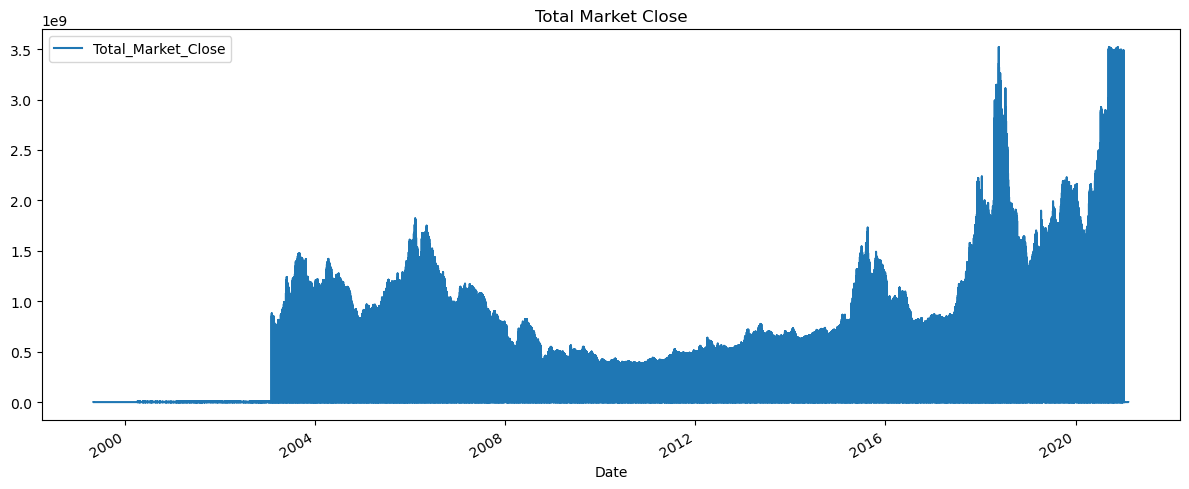

💾 Saved as 'japan_market_combined.csv'


In [34]:
# 📁 Step 1: Load and Aggregate All Stock Files
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt

# Point to folder containing the downloaded CSVs
DATA_DIR = "."  # Same as notebook directory

# Find all stock files
csv_files = sorted(glob(os.path.join(DATA_DIR, "*.csv")))
print(f"✅ Found {len(csv_files)} stock files.")

# Master dictionary to hold each stock's close price
stock_close = {}

for file_path in csv_files:
    ticker = os.path.basename(file_path).replace(".csv", "")
    df = pd.read_csv(file_path)

    # Clean and parse
    if 'Date' in df.columns and 'Close' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df[['Date', 'Close']].dropna()
        df = df.set_index('Date')
        stock_close[ticker] = df['Close']
    else:
        print(f"⚠️ Skipped: {ticker} (Missing required columns)")

# Combine all stocks into a single DataFrame
combined = pd.concat(stock_close.values(), axis=1, keys=stock_close.keys())
combined = combined.sort_index()
combined = combined.ffill().dropna(axis=1, how='any')  # Fill and drop stocks with missing data

# 🎯 Create target variable: Total Market Close
combined['Total_Market_Close'] = combined.sum(axis=1)

# Preview
print("✅ Combined shape:", combined.shape)
combined[['Total_Market_Close']].plot(figsize=(12, 5), title="Total Market Close")
plt.tight_layout()
plt.show()

# Save intermediate result
combined.to_csv("japan_market_combined.csv")
print("💾 Saved as 'japan_market_combined.csv'")


In [35]:
# ✅ Expanded Feature Engineering with Aggregation Step
import pandas as pd
import numpy as np
import time

# Ensure datetime index and sort
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# ⬅️ ADD THIS: Aggregate total close across all stocks per day
df = df.groupby("Date")["Close"].sum().to_frame(name="Total_Market_Close")

# Drop rows with missing target
target_series = df["Total_Market_Close"].dropna()

# Create expanded feature set
feature_df = pd.DataFrame(index=target_series.index)

# 1. Lag features
lags = [1, 2, 5, 10]
for lag in lags:
    feature_df[f"lag_{lag}"] = target_series.shift(lag)

# 2. Rolling mean and std
rolling_windows = [3, 7, 14]
for window in rolling_windows:
    feature_df[f"roll_mean_{window}"] = target_series.rolling(window).mean()
    feature_df[f"roll_std_{window}"] = target_series.rolling(window).std()

# 3. Rate of change (%)
feature_df["pct_change_1d"] = target_series.pct_change(1)
feature_df["pct_change_5d"] = target_series.pct_change(5)

# Drop rows with NaNs
feature_df = feature_df.dropna()

# Align target variable
target_aligned = target_series.loc[feature_df.index]

# Final features and labels
X = feature_df
y = target_aligned

print("✅ Feature engineering complete.")
print(f"📐 X shape: {X.shape}, y shape: {y.shape}")


✅ Feature engineering complete.
📐 X shape: (5443, 12), y shape: (5443,)


In [36]:
import numpy as np

# ✅ Ensure datetime index
df.index = pd.to_datetime(df.index)

# ✅ Drop NaNs and duplicates in Total_Market_Close
df = df[["Total_Market_Close"]].dropna()
df = df[~df.index.duplicated(keep='first')]

# ✅ Expanded Feature Engineering: Lags, Rolling Stats, and Returns
import pandas as pd
import numpy as np
import time

# Ensure datetime index and sort
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Drop rows with missing target
target_series = df["Total_Market_Close"].dropna()

# Create expanded feature set
feature_df = pd.DataFrame(index=target_series.index)

# 1. Lag features
lags = [1, 2, 5, 10]
for lag in lags:
    feature_df[f"lag_{lag}"] = target_series.shift(lag)

# 2. Rolling mean and std
rolling_windows = [3, 7, 14]
for window in rolling_windows:
    feature_df[f"roll_mean_{window}"] = target_series.rolling(window).mean()
    feature_df[f"roll_std_{window}"] = target_series.rolling(window).std()

# 3. Rate of change (%)
feature_df["pct_change_1d"] = target_series.pct_change(1)
feature_df["pct_change_5d"] = target_series.pct_change(5)

# Drop rows with NaNs
feature_df = feature_df.dropna()

# Align target variable
target_aligned = target_series.loc[feature_df.index]

# Final shapes
X = feature_df
y = target_aligned

print(f"✅ Feature engineering complete.")
print(f"📐 X shape: {X.shape}, y shape: {y.shape}")



✅ Feature engineering complete.
📐 X shape: (5443, 12), y shape: (5443,)


In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"🧪 Train shape: {X_train.shape}, Test shape: {X_test.shape}")


🧪 Train shape: (4354, 12), Test shape: (1089, 12)


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


MSE: 385004216786076544.00
R²: 0.3802


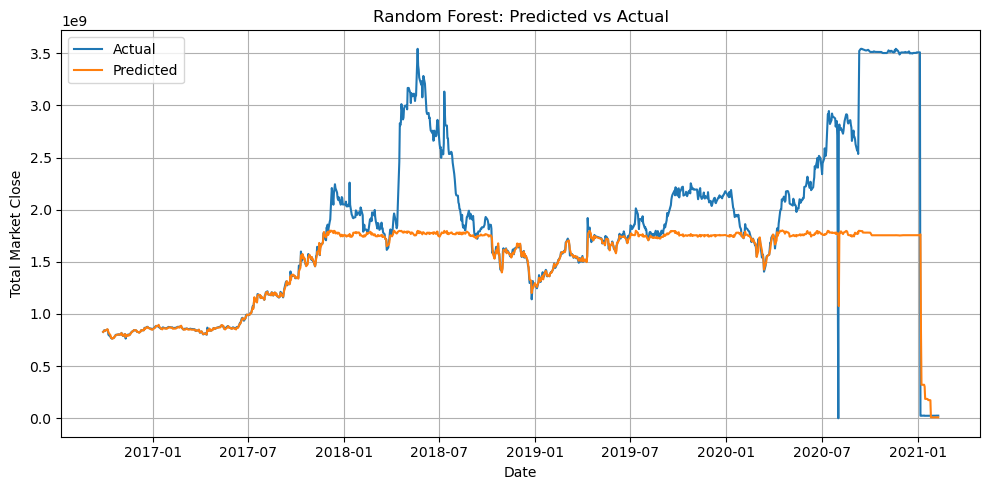

In [39]:
# ✅ Step 3A: Train Random Forest with Expanded Features
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Wrap scaled arrays with DataFrame to keep feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Train
rf = RandomForestRegressor(random_state=42, n_estimators=100)
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

rf.fit(X_train_scaled_df, y_train)

# Predict
y_pred = rf.predict(X_test_scaled_df)

# Evaluate
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

# Plot predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("Random Forest: Predicted vs Actual")
plt.xlabel("Date")
plt.ylabel("Total Market Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


RMSE: 2128878418.0192
MAE: 420191803.2729
R²: 0.0510


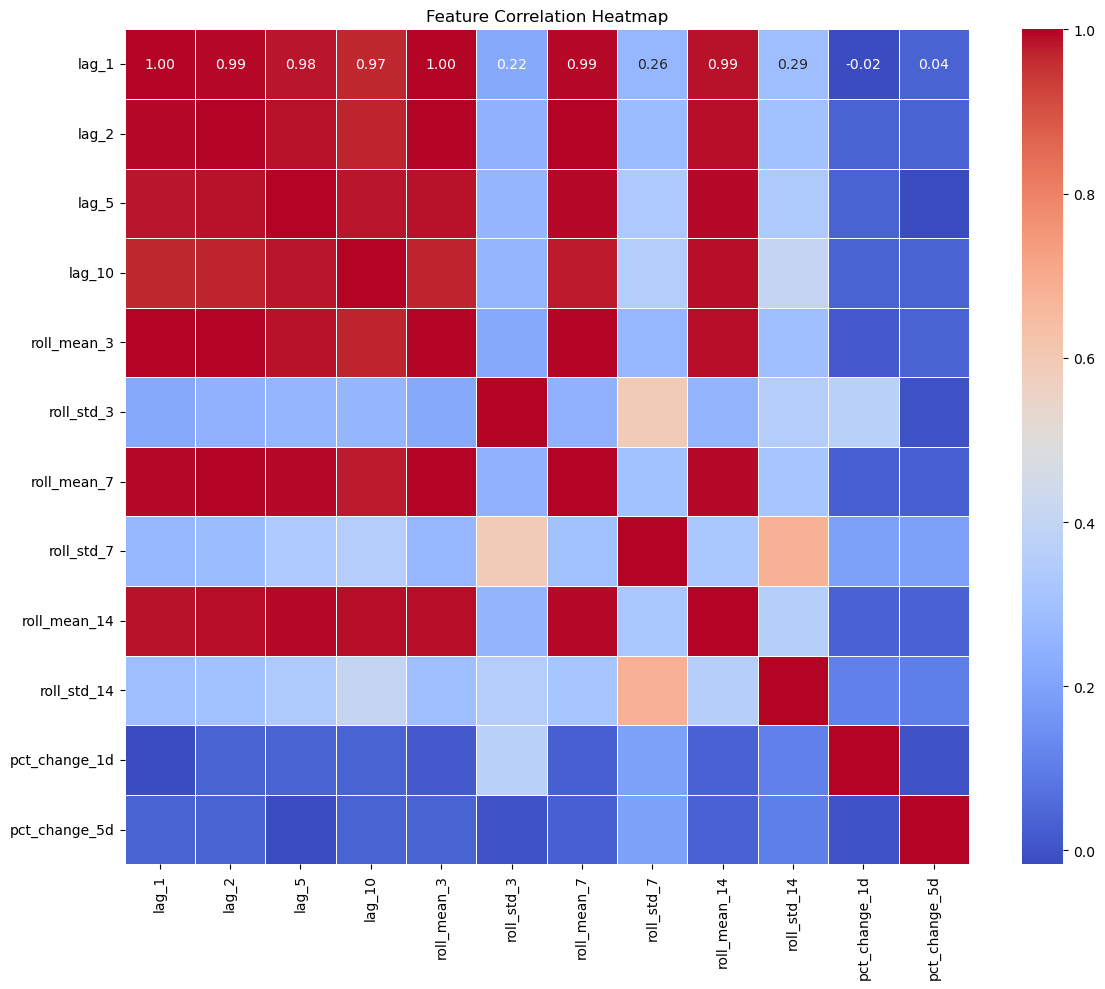

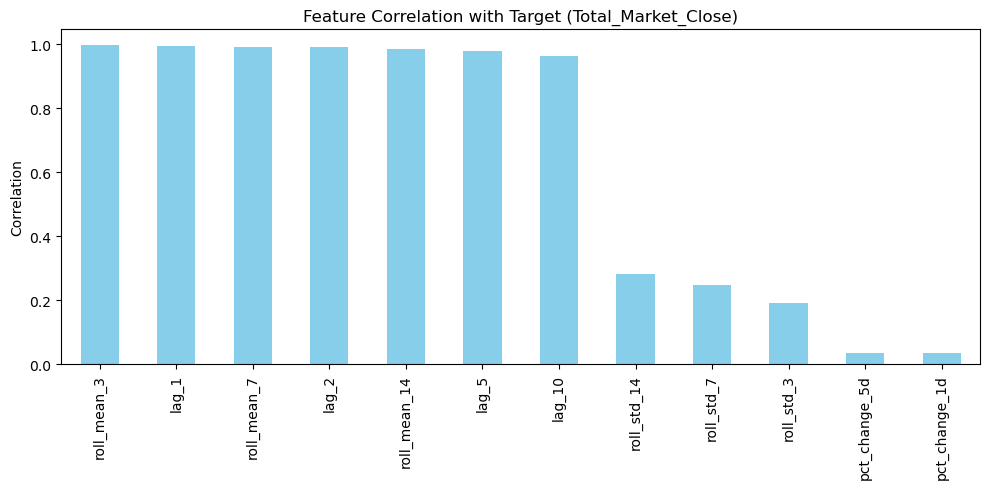

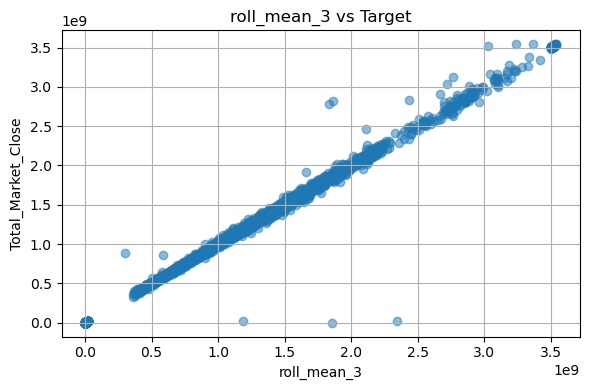

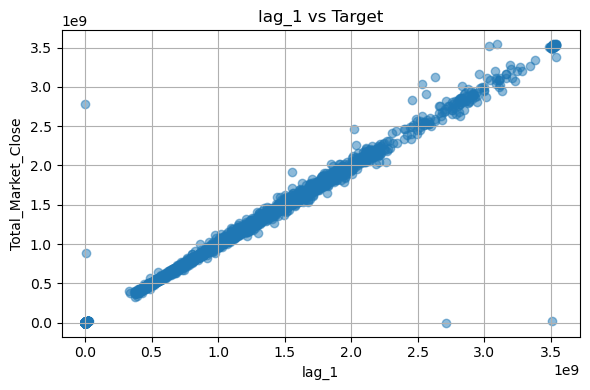

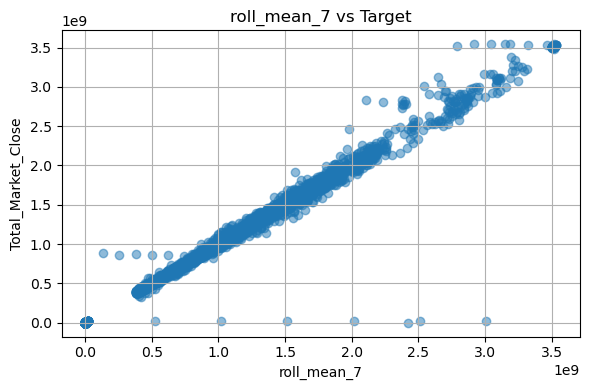

In [40]:
#Correlation Analysis and Visual Diagnostics
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# Correlation of features with target
correlations_with_target = X.corrwith(y).sort_values(ascending=False)

# Bar plot of most correlated features
plt.figure(figsize=(10, 5))
correlations_with_target.plot(kind="bar", color="skyblue")
plt.title("Feature Correlation with Target (Total_Market_Close)")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

# Optional: Scatter plot of top 3 predictors
top_features = correlations_with_target.abs().sort_values(ascending=False).head(3).index
for feat in top_features:
    plt.figure(figsize=(6, 4))
    plt.scatter(X[feat], y, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel("Total_Market_Close")
    plt.title(f"{feat} vs Target")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


🔍 Running Bayesian Optimisation...


/opt/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [29, 1, 2, 300] before, using random point [13, 2, 7, 61]
  warnings.warn(


✅ Optimisation complete.

🏆 Best Hyperparameters:
OrderedDict([('max_depth', 30), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 300)])

Final Evaluation on Holdout Fold:
RMSE: 2128878418.02
MAE:  2002203305.98
R²:   -7.6597


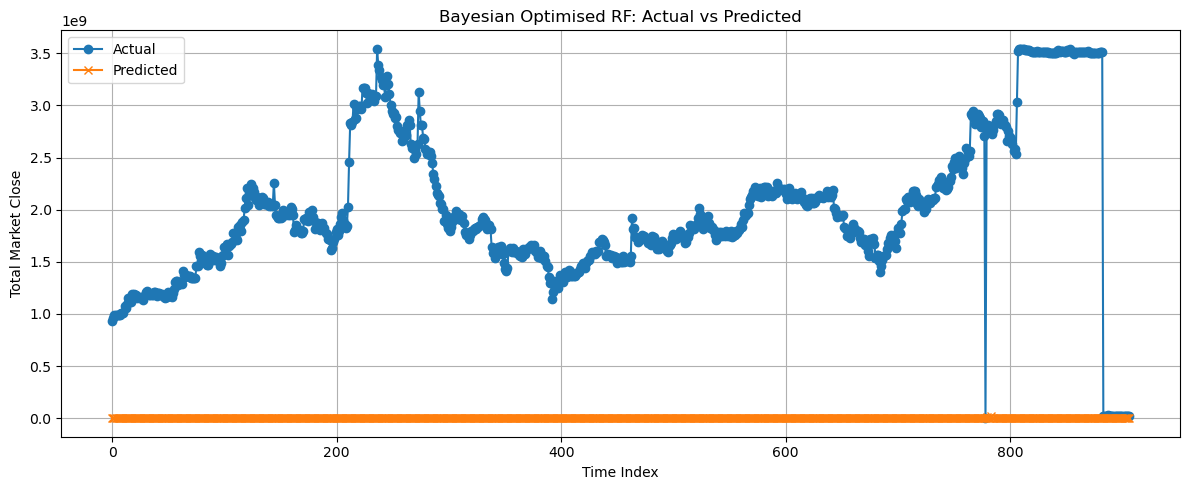

In [41]:
# ✅ Step 3B: Hyperparameter Tuning via Bayesian Optimisation (Clean Version)
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Time-aware cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define hyperparameter search space
search_space = {
    "n_estimators": Integer(50, 300),
    "max_depth": Integer(3, 30),
    "min_samples_split": Integer(2, 10),
    "min_samples_leaf": Integer(1, 5)
}

# Set up Bayesian search
opt = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    search_spaces=search_space,
    cv=tscv,
    n_iter=25,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42,
    verbose=0
)

print("🔍 Running Bayesian Optimisation...")
opt.fit(X, y)
print("✅ Optimisation complete.")

# Show best parameters
print("\n🏆 Best Hyperparameters:")
print(opt.best_params_)

# Evaluate on last fold
train_idx, test_idx = list(tscv.split(X))[-1]
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ❗ Convert scaled arrays back to DataFrames with correct feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Predict using the best estimator (avoid feature name warning)
y_pred = opt.best_estimator_.predict(X_test_scaled_df)

# Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nFinal Evaluation on Holdout Fold:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred, label="Predicted", marker='x')
plt.title("Bayesian Optimised RF: Actual vs Predicted")
plt.xlabel("Time Index")
plt.ylabel("Total Market Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
rmse_bayes = mean_squared_error(y_test, y_pred, squared=False)
mae_bayes = mean_absolute_error(y_test, y_pred)
r2_bayes = r2_score(y_test, y_pred)

print("Bayesian Optimised RF Performance")
print(f"RMSE: {rmse_bayes:.4f}")
print(f"MAE:  {mae_bayes:.4f}")
print(f"R²:   {r2_bayes:.4f}")



Bayesian Optimised RF Performance
RMSE: 2128878418.0192
MAE:  2002203305.9837
R²:   -7.6597


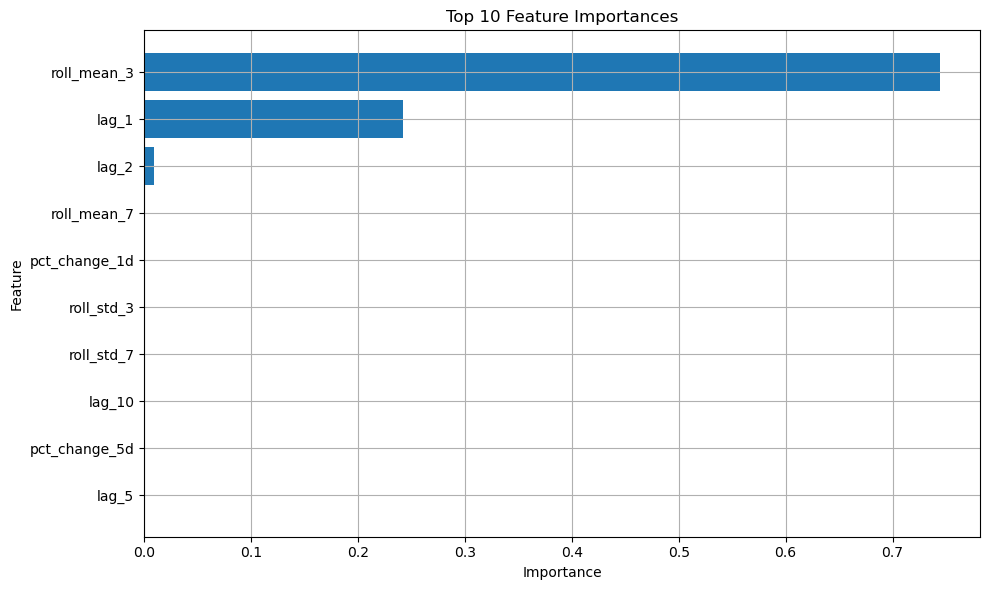

,Feature,Importance
4,roll_mean_3,0.744558
0,lag_1,0.242566
1,lag_2,0.008905
6,roll_mean_7,0.000786
10,pct_change_1d,0.000702
5,roll_std_3,0.000478
7,roll_std_7,0.000390
3,lag_10,0.000362
11,pct_change_5d,0.000332
2,lag_5,0.000324


In [42]:
# ✅ Step 4: Feature Importance from Bayesian-Optimised Random Forest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from best model
feature_importances = opt.best_estimator_.feature_importances_

# Pair with feature names
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Plot top N features
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"].head(top_n)[::-1], importance_df["Importance"].head(top_n)[::-1])
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(True)
plt.show()

# Optional: Show full table
importance_df.head(15)


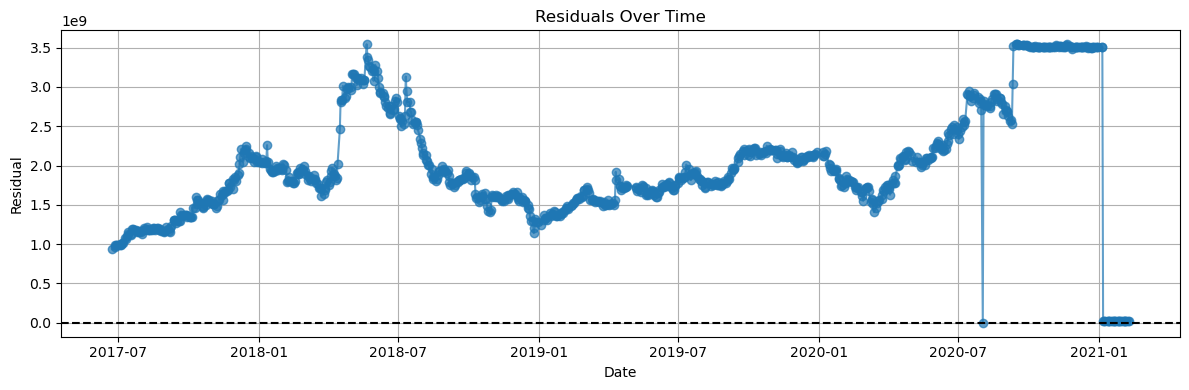

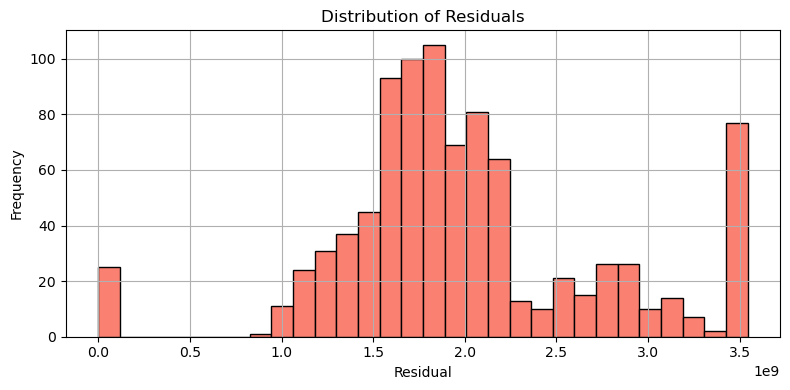

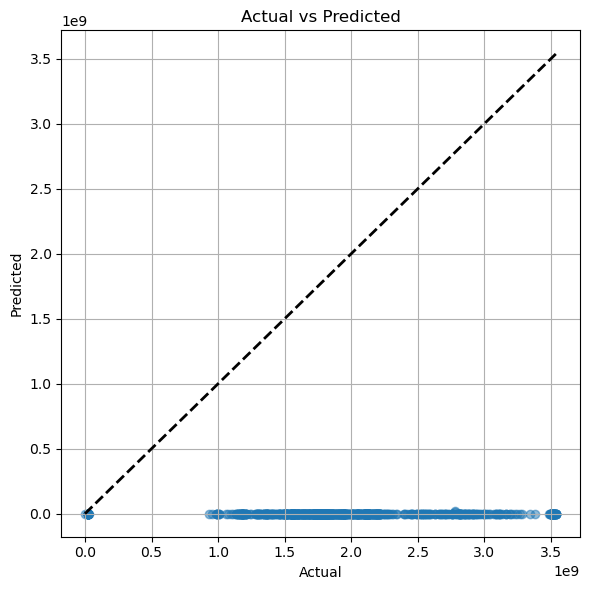

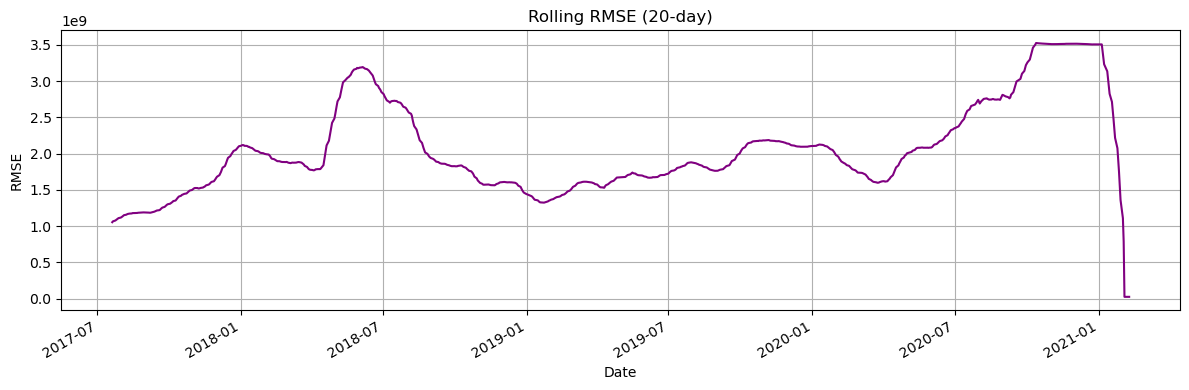

In [43]:
# ✅ Step 5: Residual Analysis and Error Diagnostics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reconstruct predictions using scaled DataFrame with feature names (if needed again)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
y_pred = opt.best_estimator_.predict(X_test_scaled_df)

# Residuals
residuals = y_test - y_pred

# Plot 1: Residuals over time
plt.figure(figsize=(12, 4))
plt.plot(y_test.index, residuals, marker='o', linestyle='-', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals Over Time")
plt.ylabel("Residual")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Distribution of residuals
plt.figure(figsize=(8, 4))
plt.hist(residuals.replace([np.inf, -np.inf], np.nan).dropna(), bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.grid(True)
plt.show()

# Plot 3: Actual vs Predicted Scatter
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.tight_layout()
plt.grid(True)
plt.show()

# Optional: Rolling RMSE (error volatility)
rolling_window = 20
rolling_rmse = residuals.rolling(rolling_window).apply(lambda x: (x**2).mean()**0.5)

plt.figure(figsize=(12, 4))
rolling_rmse.plot(color='purple')
plt.title(f"Rolling RMSE ({rolling_window}-day)")
plt.ylabel("RMSE")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


XGBoost Performance:
MSE: 496686811784322432.00
MAE: 420191803.27
R²:  0.0510


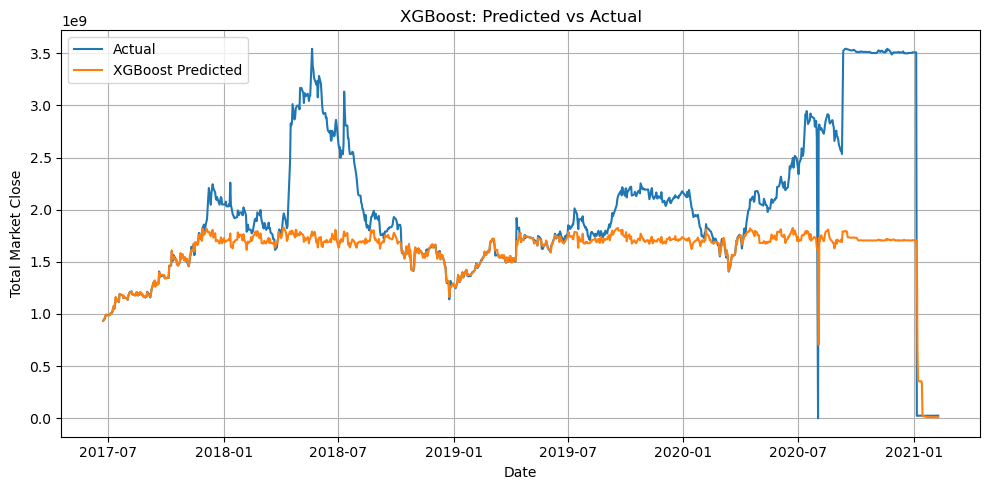

In [44]:
# ✅ Step 6A: Train XGBoost Model for Comparison
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Train XGBoost on same scaled train/test
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbosity=0
)

xgb.fit(X_train_scaled, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test_scaled)

# Evaluate
mse = mean_squared_error(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²:  {r2:.4f}")

# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_xgb, label="XGBoost Predicted")
plt.title("XGBoost: Predicted vs Actual")
plt.xlabel("Date")
plt.ylabel("Total Market Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
print("🔍 Model Comparison Summary")
comparison_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "RMSE": [
        mean_squared_error(y_test, rf.predict(X_test_scaled_df), squared=False),
        mean_squared_error(y_test, y_pred_xgb, squared=False)
    ],
    "MAE": [
        mean_absolute_error(y_test, rf.predict(X_test_scaled_df)),
        mean_absolute_error(y_test, y_pred_xgb)
    ],
    "R²": [
        r2_score(y_test, rf.predict(X_test_scaled_df)),
        r2_score(y_test, y_pred_xgb)
    ]
})

print(comparison_df)


🔍 Model Comparison Summary
           Model          RMSE           MAE       R²
0  Random Forest  6.795353e+08  3.974277e+08  0.11768
1        XGBoost  7.047601e+08  4.201918e+08  0.05096


In [46]:
import joblib
import os

# Create output directory
os.makedirs("model_output", exist_ok=True)

# Save the best Bayesian-optimised RF model
joblib.dump(opt.best_estimator_, "model_output/best_model_rf.pkl")

# Save the scaler used for inputs
joblib.dump(scaler, "model_output/scaler.pkl")

# Save final feature names (for deployment / inference)
X.columns.to_series().to_csv("model_output/feature_names.csv", index=False)

print("✅ Model, scaler, and feature names exported.")


✅ Model, scaler, and feature names exported.


In [47]:
# Save sample predictions for inspection
pred_df = pd.DataFrame({
    "Date": y_test.index,
    "Actual": y_test.values,
    "Predicted_RF": y_pred
})
pred_df.to_csv("model_output/sample_predictions.csv", index=False)

print("✅ Sample predictions saved.")


✅ Sample predictions saved.
